# DWI Classification Model @AiiLAB

### Import Library

In [1]:
import pandas as pd
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D # type: ignore
from tensorflow.keras.optimizers import Adam   # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # type: ignore 
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore

2024-07-15 21:40:45.998172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

print( 'Tensorflow Version:', tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.16.2
Num GPUs Available:  0


### Split the data

In [3]:
# Set paths
original_dataset_dir = '/Users/Sribilone/AiiLAB/_dwi_project/image_original'
base_dir = 'dwi_dataset_evo'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [16]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the function to create subdirectories
def create_subdirs(base_dir):
    os.makedirs(os.path.join(base_dir, 'positive_case'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'negative_case'), exist_ok=True)

create_subdirs(train_dir)
create_subdirs(val_dir)
create_subdirs(test_dir)


In [17]:
# Function to split data into train, validation, and test sets
def split_data(original_dir, train_dir, val_dir, test_dir, train_size=475, val_size=115):
    for category in ['positive_case', 'negative_case']:
        category_path = os.path.join(original_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)
        
        # Split data
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]
        
        # Copy train images
        print(f"Copying training images for {category}...")
        for image in tqdm(train_images, desc=f"Training {category}"):
            shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category))
        
        # Copy validation images
        print(f"Copying validation images for {category}...")
        for image in tqdm(val_images, desc=f"Validation {category}"):
            shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category))
        
        # Copy test images
        print(f"Copying test images for {category}...")
        for image in tqdm(test_images, desc=f"Testing {category}"):
            shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category))

In [18]:
# Split the data
split_data(original_dataset_dir, train_dir, val_dir, test_dir, train_size=475, val_size=115)

Copying training images for positive_case...


Training positive_case: 100%|██████████| 475/475 [00:00<00:00, 665.65it/s]


Copying validation images for positive_case...


Validation positive_case: 100%|██████████| 115/115 [00:00<00:00, 635.99it/s]


Copying test images for positive_case...


Testing positive_case: 100%|██████████| 26/26 [00:00<00:00, 636.32it/s]


Copying training images for negative_case...


Training negative_case: 100%|██████████| 475/475 [00:00<00:00, 688.85it/s]


Copying validation images for negative_case...


Validation negative_case: 100%|██████████| 115/115 [00:00<00:00, 809.20it/s]


Copying test images for negative_case...


Testing negative_case: 100%|██████████| 26/26 [00:00<00:00, 450.51it/s]


### Image Pre-Processing

In [4]:
# Define batch size
batch_size = 32
img_height = 299
img_width = 299

# Create a dataset from directories
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Use `.cache()` and `.prefetch()` to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1300 files belonging to 2 classes.
Found 320 files belonging to 2 classes.


In [5]:
# Load the EfficientNetB0 model, pretrained on ImageNet
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Load the ResNet50 model, pretrained on ImageNet
# from tensorflow.keras.applications import ResNet50
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Load VGG16 model + higher level layers
# from tensorflow.keras.applications import VGG16, VGG19
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [6]:
# # Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification with sigmoid activation

# Add custom layers
# x = base_model.output
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(1, activation='sigmoid')(x)

In [7]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Compile the model
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# Custom callback to save model with accuracy in filename
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_accuracy', mode='max', verbose=1):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float('inf') if mode == 'max' else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if self.mode == 'max' and current > self.best:
            self.best = current
            self.save_model(current, epoch)
        elif self.mode == 'min' and current < self.best:
            self.best = current
            self.save_model(current, epoch)

    def save_model(self, current, epoch):
        filepath = self.filepath.format(epoch=epoch+1, accuracy=current)
        if self.verbose > 0:
            print(f'\nEpoch {epoch+1}: {self.monitor} improved to {current:.4f}, saving model to {filepath}')
        self.model.save(filepath)

# Define callbacks
model_folder = 'InceptionV3'
checkpoint_filepath = f'./checkpoint/{model_folder}'

os.makedirs(checkpoint_filepath, exist_ok=True)

checkpoint_filepath = os.path.join(checkpoint_filepath, 'model_epoch_{epoch:02d}_accuracy_{accuracy:.4f}.keras') #'./checkpoint/{model_folder}/model_epoch_{epoch:02d}_accuracy_{accuracy:.4f}.keras'
callbacks = [
    CustomModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)
]

In [10]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5357 - loss: 7.0841
Epoch 1: val_accuracy improved to 0.7000, saving model to ./checkpoint/InceptionV3/model_epoch_01_accuracy_0.7000.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5372 - loss: 6.9981 - val_accuracy: 0.7000 - val_loss: 0.8124 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7244 - loss: 0.6037 - val_accuracy: 0.6531 - val_loss: 0.8208 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7602 - loss: 0.5643 - val_accuracy: 0.6969 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7503 - loss: 0.5510
Epoch 4: val_accuracy improved to 0.7063, saving model to ./checkpoint/InceptionV3/model_epoch_04_accuracy_0.7063.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.7509 - loss: 0.5501 - val_accuracy: 0.7063 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 5/10

In [11]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

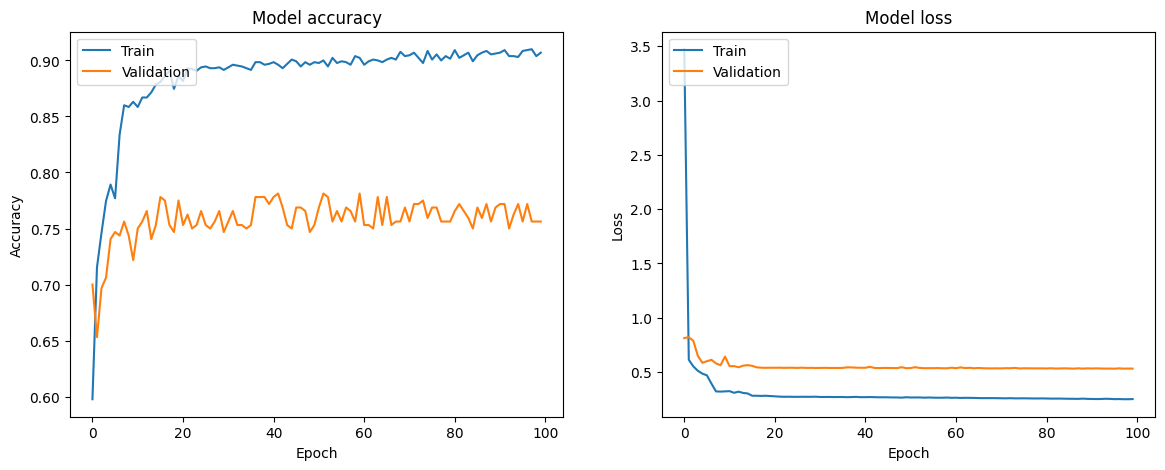

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Prediction

In [22]:
# model_path = './checkpoint/VGG19/model_epoch_98_accuracy_0.8938.keras'
model_path = '/Users/Sribilone/AiiLAB/_dwi_project/_code/image_classification/checkpoint/InceptionV3/model_epoch_42_accuracy_0.7812.keras'
model = load_model(model_path)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,589,989 (86.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 524,804 (2.00 MB)

In [16]:
def load_and_preprocess_image(img_path, img_height=img_height, img_width=img_width):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # เพิ่มมิติสำหรับ batch
    img_array /= 255.0  # Normalize ให้เหมือนกับตอน train
    return img_array

def predict_image(model_path, img_path, img_height=img_height, img_width=img_width):
    # โหลดโมเดล
    model = load_model(model_path)
    
    # เตรียมการ Pre-process รูปภาพ
    img_array = load_and_preprocess_image(img_path, img_height, img_width)
    
    # Predict ผลลัพธ์
    prediction = model.predict(img_array)
    
    # แปลงผลลัพธ์จาก sigmoid เพื่อให้ได้ผลลัพธ์เป็น 0 หรือ 1
    result = (prediction > 0.5).astype(int)
    
    return result[0][0], prediction[0][0]

def display_prediction(model_path, img_path):
    result, confidence = predict_image(model_path, img_path)
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    title = f'Prediction: {"Positive" if result == 1 else "Negative"}\nConfidence: {confidence * 100:.2f}%'
    plt.title(title)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


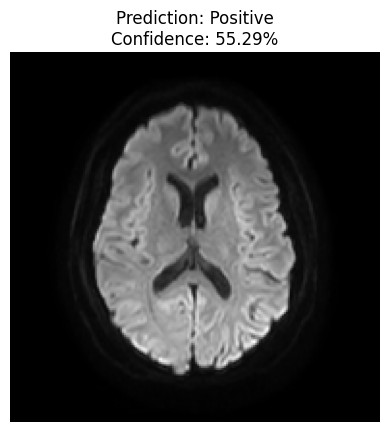

In [17]:

img_path = '/Users/Sribilone/AiiLAB/_dwi_project/_code/image_classification/dwi_dataset/test/negative_case/B008_03e28109_anon.png'
# img_path = '/Users/Sribilone/AiiLAB/_dwi_project/_code/image_classification/dwi_dataset/test/positive_case/A004_039f5802_anon.png'
display_prediction(model_path, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


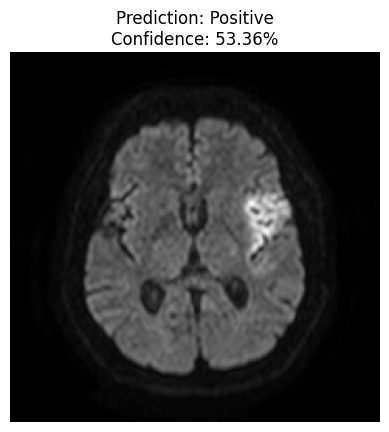

In [18]:

img_path = '/Users/Sribilone/AiiLAB/_dwi_project/_code/image_classification/dwi_dataset/test/positive_case/A004_039f5802_anon.png'
display_prediction(model_path, img_path)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# ฟังก์ชันสำหรับโหลดและเตรียมการ Pre-process รูปภาพ
def load_and_preprocess_image_10x(img_path, img_height=img_height, img_width=img_width):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # เพิ่มมิติสำหรับ batch
    img_array /= 255.0  # Normalize ให้เหมือนกับตอน train
    return img_array

# ฟังก์ชันสำหรับ Predict ผลลัพธ์จากโมเดล
def predict_image_10x(model_path, img_paths, img_height=img_height, img_width=img_width):
    # โหลดโมเดล
    model = load_model(model_path)

    results = []
    confidences = []

    for img_path in img_paths:
        # เตรียมการ Pre-process รูปภาพ
        img_array = load_and_preprocess_image_10x(img_path, img_height, img_width)

        # Predict ผลลัพธ์
        prediction = model.predict(img_array)

        # แปลงผลลัพธ์จาก sigmoid เพื่อให้ได้ผลลัพธ์เป็น 0 หรือ 1
        result = (prediction > 0.5).astype(int)

        results.append(result[0][0])
        confidences.append(prediction[0][0])

    return results, confidences

# ฟังก์ชันสำหรับแสดงผลลัพธ์
def display_predictions_10x(model_path, img_paths):
    results, confidences = predict_image_10x(model_path, img_paths)

    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(img_paths):
        img = image.load_img(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        title = f'Prediction: {"Positive" if results[i] == 1 else "Negative"}\nConfidence: {confidences[i] * 100:.2f}%'
        plt.title(title)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


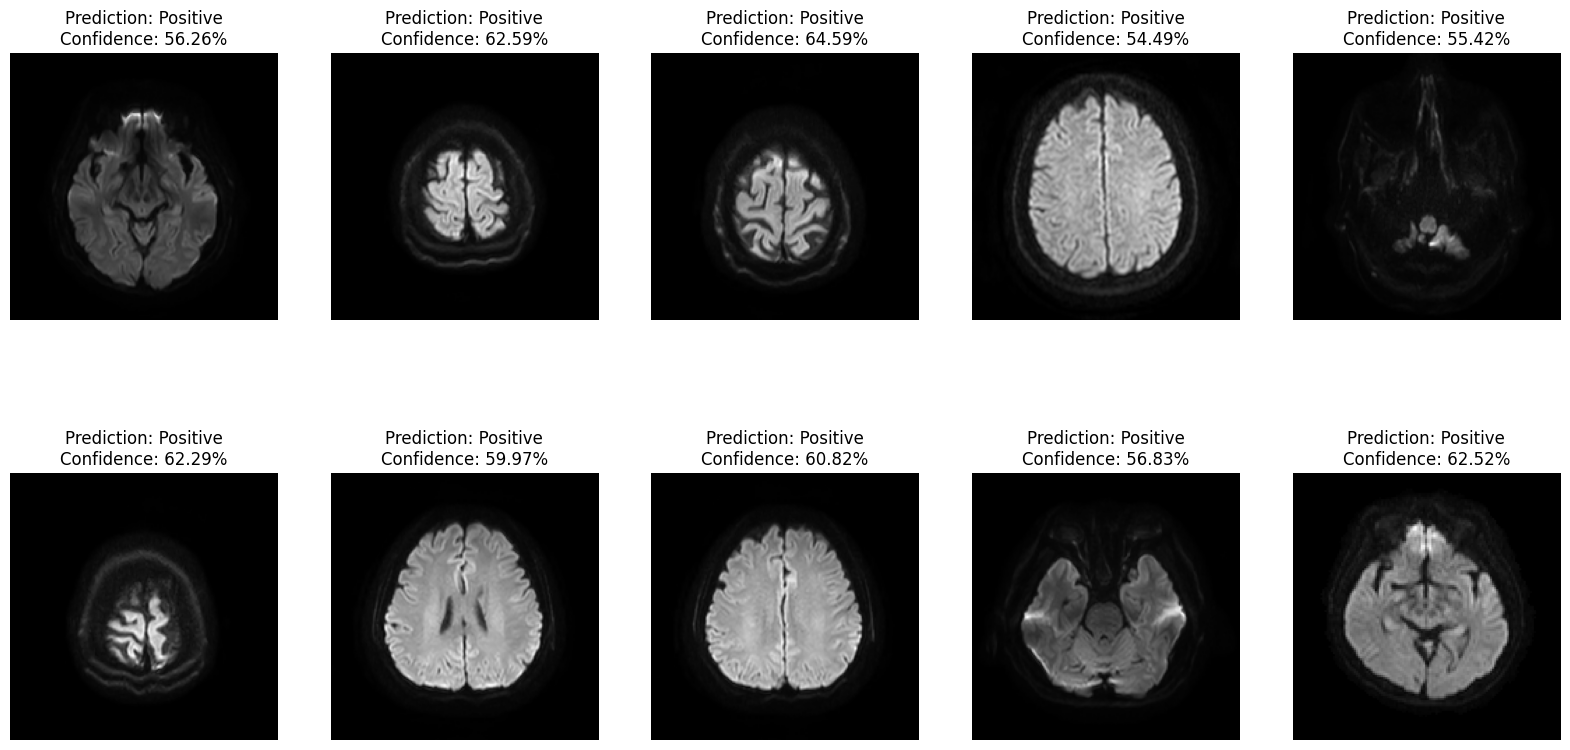

In [20]:
img_folder = './dwi_dataset/test/negative_case/'  # กำหนด path ไปยังโฟลเดอร์ที่เก็บรูปภาพที่ต้องการทดสอบ
img_paths = [os.path.join(img_folder, img) for img in os.listdir(img_folder)[:10]]  # เลือก 10 รูปแรก

display_predictions_10x(model_path, img_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


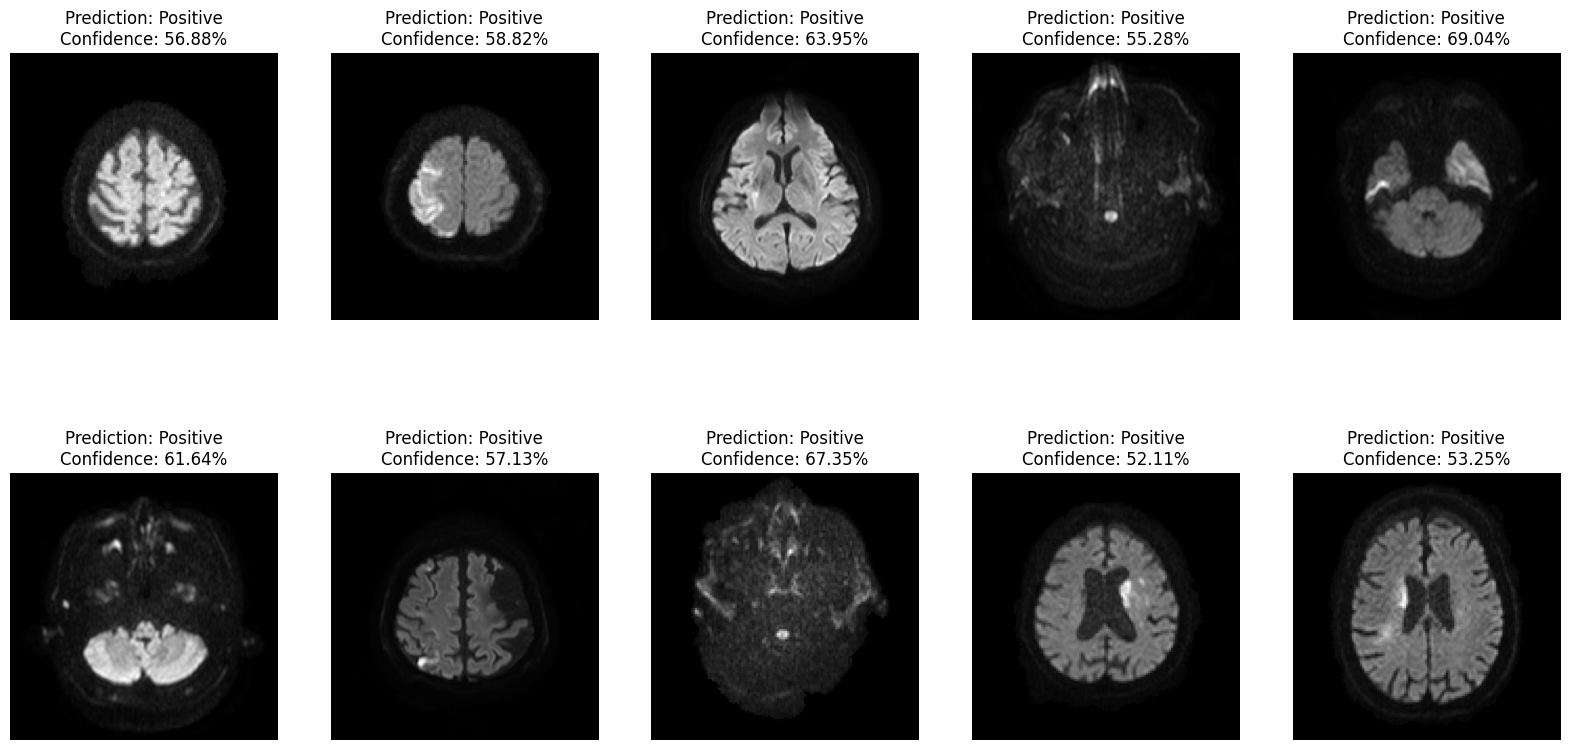

In [21]:
img_folder = './dwi_dataset/test/positive_case/'  # กำหนด path ไปยังโฟลเดอร์ที่เก็บรูปภาพที่ต้องการทดสอบ
img_paths = [os.path.join(img_folder, img) for img in os.listdir(img_folder)[:10]]  # เลือก 10 รูปแรก

display_predictions_10x(model_path, img_paths)